## Importing the required libraries

In [1]:
# !pip install librosa

In [2]:
# !pip install tensorflow

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
# from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [4]:
from keras import regularizers

In [5]:
import os

In [6]:
mylist= os.listdir('Audio_Speech_Actors_01-24/')

In [7]:
type(mylist)

list

In [8]:
print(mylist[800])

03-01-05-02-01-02-09.wav


In [9]:
print(mylist[800][18:-4])

09


## Plotting the audio file's waveform and its spectrogram

In [10]:
# data, sampling_rate = librosa.load('RawData/f11 (2).wav')
data, sampling_rate = librosa.load('Audio_Speech_Actors_01-24/03-01-02-01-02-02-02.wav')

Populating the interactive namespace from numpy and matplotlib


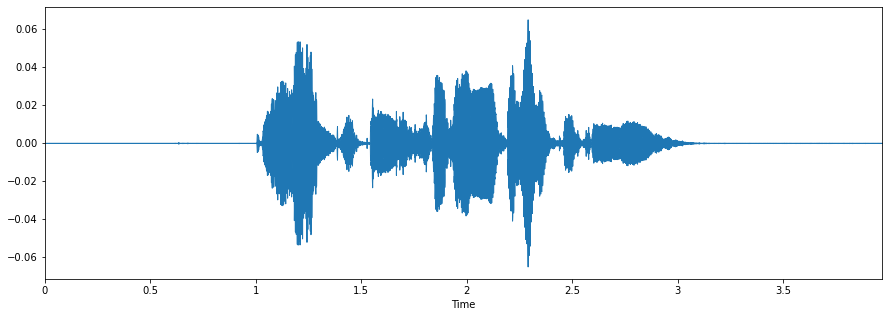

In [11]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

<ipython-input-12-a1709c81f8e2>:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('Audio_Speech_Actors_01-24/03-01-05-01-01-01-02.wav')
<ipython-input-12-a1709c81f8e2>:28: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


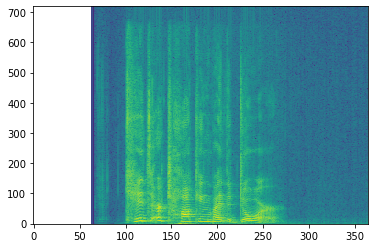

In [12]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys
import pandas as pd


# sr,x = scipy.io.wavfile.read('RawData/f10 (2).wav')
sr,x = scipy.io.wavfile.read('Audio_Speech_Actors_01-24/03-01-05-01-01-01-02.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [13]:
feeling_list=[]
for item in mylist:
#     if item[6:-16]=='01' and int(item[18:-4])%2==0:
#         feeling_list.append('female_neutral')
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
#     elif item[6:-16]=='07' and int(item[18:-4])%2==0:
#         feeling_list.append('female_pain')
#     elif item[6:-16]=='07' and int(item[18:-4])%2==1:
#         feeling_list.append('male_pain')
#     elif item[6:-16]=='08' and int(item[18:-4])%2==0:
#         feeling_list.append('female_shocked')
#     elif item[6:-16]=='08' and int(item[18:-4])%2==1:
#         feeling_list.append('male_shocked')
#     elif item[:1]=='a':
#         feeling_list.append('male_angry')
#     elif item[:1]=='f':
#         feeling_list.append('male_fearful')
#     elif item[:1]=='h':
#         feeling_list.append('male_happy')
#     #elif item[:1]=='n':
#         #feeling_list.append('neutral')
#     elif item[:2]=='sa':
#         feeling_list.append('male_sad')

In [14]:
labels = pd.DataFrame(feeling_list)

In [15]:
labels[:5]

,0
0,male_neutral
1,male_neutral
2,male_neutral
3,male_neutral
4,male_neutral


## Getting the features of audio files using librosa

In [16]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
#     print(index,y)
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08':#and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
#         X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)

        X, sample_rate = librosa.load('Audio_Speech_Actors_01-24/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [17]:
df[:5]

,feature
0,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."
1,"[-65.70765, -65.70765, -63.11472, -61.518997, ..."
2,"[-65.4825, -65.4825, -65.4825, -65.4825, -65.4..."
3,"[-64.52845, -64.52845, -64.52845, -64.52845, -..."
4,"[-62.36431, -59.934727, -61.869602, -67.49577,..."


In [18]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [19]:
newdf = pd.concat([df3,labels], axis=1)

In [20]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [21]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-57.447464,-58.896500,-58.750996,-57.405678,-60.078484,-63.426800,-62.638542,-61.082741,-60.234661,male_neutral
1,-65.707649,-65.707649,-63.114719,-61.518997,-61.097141,-63.424599,-63.720066,-56.854614,-55.168972,-54.639999,...,-39.792141,-40.613159,-41.209202,-41.439201,-43.994286,-49.399620,-50.591599,-49.144051,-48.705654,male_neutral
2,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,...,-31.346556,-34.310772,-35.800705,-35.936115,-37.631844,-40.119411,-41.662888,-41.323643,-40.710770,male_neutral
3,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-65.928223,...,-48.674301,-48.596073,-47.602745,-43.049198,-42.659542,-43.188560,-44.001244,-43.610100,-44.698246,male_neutral
4,-62.364311,-59.934727,-61.869602,-67.495773,-71.071808,-65.679817,-63.394402,-65.503349,-61.856644,-60.005428,...,-39.071327,-41.897121,-40.865437,-38.290604,-36.372398,-37.915779,-40.026127,-43.383774,-43.965401,male_neutral


In [22]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
854,-56.514473,-58.217705,-59.190144,-58.814827,-59.682495,-60.168167,-60.022030,-59.729637,-59.597092,-59.299667,...,-48.448074,-48.095615,-48.527493,-49.944084,-50.918087,-51.535160,-52.271111,-52.529640,-53.703804,male_fearful
444,-62.949284,-61.668442,-62.001259,-60.142002,-60.433285,-64.699104,-69.395538,-67.677116,-68.727585,-66.632462,...,-59.054630,-56.488419,-58.638565,-60.799847,-65.953331,-69.733299,-69.372871,-68.776337,-69.733299,male_sad
914,-44.709846,-44.053963,-45.805027,-45.685276,-45.924458,-44.944908,-43.104404,-42.355068,-36.614601,-29.646311,...,-36.173859,-34.418983,-34.007683,-33.208138,-30.305372,-32.002056,-33.987125,-36.432674,-37.229710,male_fearful
243,-61.677837,-61.677837,-61.677837,-61.677837,-61.677837,-61.677837,-61.677837,-61.677837,-61.677837,-61.677837,...,-58.219059,-56.927776,-55.322388,-56.383835,-54.317219,-54.811531,-56.263454,-58.056526,-56.060867,female_happy
509,-69.459000,-69.451630,-68.840073,-69.228561,-68.105865,-66.812645,-67.263512,-68.969070,-67.278656,-67.232086,...,-52.635822,-53.371605,-52.580357,-52.301826,-53.280594,-51.640526,-52.419254,-49.779514,-45.069885,female_sad
372,-54.919857,-55.033676,-54.223122,-53.123676,-53.233986,-54.257576,-53.742397,-54.312252,-55.346966,-55.346966,...,-54.673683,-54.720745,-54.902412,-55.252754,-55.346966,-55.346966,-55.346966,-55.346966,-55.346966,male_happy
882,-28.373049,-27.978804,-30.898752,-33.169971,-35.058517,-36.364769,-37.334827,-39.245750,-37.967350,-37.864887,...,-45.189236,-47.301262,-48.045071,-47.382919,-45.342464,-44.985943,-44.739136,-45.937767,-45.638859,male_fearful
211,-55.729866,-55.729866,-55.729866,-55.729866,-55.729866,-55.729866,-55.729866,-55.729866,-55.729866,-55.729866,...,-54.952694,-53.752495,-54.537338,-55.653439,-55.729866,-55.729866,-55.729866,-55.690510,-53.630718,female_calm
665,-59.042679,-59.042679,-59.042679,-59.042679,-59.042679,-59.042679,-59.042679,-59.042679,-59.042679,-59.042679,...,-52.284061,-52.648697,-53.670570,-54.022274,-55.960472,-56.301655,-55.805397,-57.557350,-58.618046,female_angry
523,-49.568260,-49.568260,-49.568260,-49.568260,-49.568260,-49.568260,-49.565701,-49.920223,-49.648415,-48.131737,...,-40.311028,-38.825096,-40.422237,-40.474083,-38.832355,-38.269413,-37.918625,-30.902903,-23.534830,female_sad


In [23]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [24]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [25]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_fearful
697,-50.396957,-50.396957,-50.396957,-50.396957,-50.396957,-50.396957,-50.396957,-50.396957,-50.396957,-50.396957,...,-26.351488,-26.162306,-25.729452,-27.235050,-30.739927,-34.696907,-34.492184,-34.986649,-36.733658,female_angry
864,-44.590069,-45.006252,-45.195320,-43.043465,-43.082603,-44.332863,-44.626202,-44.435585,-43.747700,-45.732262,...,-29.308031,-26.958963,-26.997744,-27.167727,-26.274006,-26.835957,-26.284428,-12.792420,-5.248500,male_fearful
129,-52.437050,-51.064896,-50.577312,-49.825336,-50.883064,-49.652046,-49.599503,-53.588341,-54.398037,-52.963188,...,-45.700584,-44.568455,-47.591030,-47.851608,-46.456711,-46.637821,-45.868595,-46.566452,-47.364120,female_calm
663,-52.731972,-52.731972,-52.731972,-52.752178,-53.205021,-53.342686,-53.324959,-52.674904,-53.033257,-53.095463,...,-30.264273,-33.084885,-34.377354,-33.943920,-30.076904,-31.443645,-32.603565,-37.606949,-45.258446,female_angry
398,-36.811287,-39.613823,-47.779598,-47.867825,-48.520847,-49.263321,-50.615704,-50.911179,-50.581490,-52.066902,...,-49.006226,-49.691563,-50.794712,-51.054775,-53.019157,-48.176636,-47.039410,-49.845280,-50.194027,male_happy
294,-51.821976,-54.558968,-54.594200,-54.274563,-54.368977,-54.870335,-55.241070,-54.999390,-55.256226,-56.148396,...,-24.167166,-25.164309,-26.231611,-25.638435,-24.241289,-24.341442,-24.899202,-21.364260,-15.935067,male_happy
383,-52.388832,-52.388832,-52.388832,-52.388832,-54.024086,-54.198566,-53.286076,-52.388832,-52.388832,-52.399776,...,-44.524052,-46.362766,-46.383038,-47.492374,-51.348980,-51.252678,-50.509342,-49.606155,-47.599140,female_happy
940,-36.852459,-37.437809,-36.782372,-34.506187,-34.420010,-37.534943,-34.760212,-33.997925,-35.101974,-29.867584,...,-49.102592,-49.452156,-49.057392,-49.239861,-50.141788,-50.406551,-49.450447,-49.917412,-50.642719,male_fearful
510,-58.525986,-57.831261,-58.504379,-59.658733,-59.949455,-59.686150,-57.399700,-57.776566,-57.546524,-59.210159,...,-37.873840,-37.110771,-33.075211,-30.842253,-29.883247,-29.687969,-30.495230,-30.565004,-30.627390,male_sad


In [26]:
trainfeatures = train.iloc[:, :-1]

In [27]:
trainlabel = train.iloc[:, -1:]

In [28]:
testfeatures = test.iloc[:, :-1]

In [29]:
testlabel = test.iloc[:, -1:]

In [30]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()
# print(y_test.shape)
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\Users\vidhi.mittal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [31]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [32]:
X_train.shape

(798, 216)

## Changing dimension for CNN model

In [33]:
from tensorflow.keras import optimizers

In [34]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [35]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))


# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))


model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
opt = optimizers.RMSprop(lr=0.00001, decay=1e-6)

C:\Users\vidhi.mittal\Anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [36]:
# model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          1536      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 dropout (Dropout)           (None, 216, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 128)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 27, 128)           82048     
                                                        

In [38]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
# model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [39]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700


ValueError: in user code:

    File "C:\Users\vidhi.mittal\Anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\vidhi.mittal\Anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\vidhi.mittal\Anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\vidhi.mittal\Anaconda3\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "C:\Users\vidhi.mittal\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\vidhi.mittal\Anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\vidhi.mittal\Anaconda3\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\vidhi.mittal\Anaconda3\lib\site-packages\keras\losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\vidhi.mittal\Anaconda3\lib\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 11) and (None, 10) are incompatible


In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

## Predicting emotions on the test data

In [ ]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

In [ ]:
preds

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
preds1

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

In [ ]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [ ]:
finaldf[170:180]

In [ ]:
finaldf.groupby('actualvalues').count()

In [ ]:
finaldf.groupby('predictedvalues').count()

In [ ]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [ ]:
data, sampling_rate = librosa.load('output1.wav')

In [ ]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [ ]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('sample.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [ ]:
livedf2= pd.DataFrame(data=livedf2)

In [ ]:
livedf2 = livedf2.stack().to_frame().T

In [ ]:
livedf2

In [ ]:
twodim= np.expand_dims(livedf2, axis=2)

In [ ]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

In [ ]:
livepreds

In [ ]:
livepreds1=livepreds.argmax(axis=1)

In [ ]:
liveabc = livepreds1.astype(int).flatten()

In [ ]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions